# Customer Segmentation using RFM & KMeans

In this project, we apply **RFM analysis** (Recency, Frequency, Monetary) to retail customer data to identify distinct customer segments using **KMeans clustering**. This segmentation is useful for marketing strategies, customer loyalty, and retention planning.


In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Data Loading and Overview

We begin by loading the transaction data and reviewing the first few rows to understand the structure. The key columns of interest are:
- `order_date`
- `order_id`
- `customer_id`
- `profit`


In [93]:
import os
os.environ["OMP_NUM_THREADS"] = "7"

In [94]:
stor_df = pd.read_csv(r"D:\Data Science\github\Customer-Segmentation-for-a-Retail-Business\data\raw\store.csv")

In [95]:
stor_df.head(3)

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,city,state,...,category,sub-category,product_name,sales,quantity,discount,profit,shipping_cost,order_priority,sales_year
0,42433,AG-2011-2040,2011-01-01,2011-06-01,Standard Class,TB-11280,Toby Braunhardt,Consumer,Constantine,Constantine,...,Office Supplies,Storage,"Tenex Lockers, Blue",408.300,2,0.0,106.140,35.46,Medium,2011
1,22253,IN-2011-47883,2011-01-01,2011-08-01,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,...,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.366,3,0.1,36.036,9.72,Medium,2011
2,48883,HU-2011-1220,2011-01-01,2011-05-01,Second Class,AT-735,Annie Thurman,Consumer,Budapest,Budapest,...,Office Supplies,Storage,"Tenex Box, Single Width",66.120,4,0.0,29.640,8.17,High,2011


In [96]:
from datetime import datetime

In [97]:
stor_df['order_date'] = pd.to_datetime(stor_df['order_date'])

In [98]:
reference_date = stor_df['order_date'].max() + pd.Timedelta(days=1)

## 2. RFM Feature Engineering

We compute:
- **Recency**: Days since last purchase
- **Frequency**: Number of unique orders
- **Monetary**: Total profit from the customer


In [99]:
rfm = stor_df.groupby('customer_id').agg({
    'order_date': lambda x: (reference_date - x.max()).days,  # Recency
    'order_id': 'nunique',                                    # Frequency
    'profit': 'sum'                                           # Monetary (profit)
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary_Profit']

In [100]:
rfm.sort_values("Monetary_Profit", ascending=False).head()

,CustomerID,Recency,Frequency,Monetary_Profit
1489,TC-20980,54,28,8787.47490
1243,RB-19360,50,25,8523.95150
1353,SC-20095,76,28,8106.21790
150,BE-11335,36,37,7790.69630
656,HL-15040,24,20,7657.50178


## 3. Feature Scaling

We scale the RFM features using `StandardScaler` to normalize them before clustering.


In [101]:
from sklearn.preprocessing import StandardScaler

In [102]:
features = rfm[['Recency', 'Frequency', 'Monetary_Profit']]

In [103]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(features)

In [104]:
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=features.columns)
rfm_scaled_df.head()

,Recency,Frequency,Monetary_Profit
0,-0.622788,0.264053,-0.357866
1,-0.638432,0.640847,-0.184831
2,0.229843,0.358251,0.446954
3,-0.481986,1.865430,1.602818
4,-0.669722,-0.866332,-0.291694


## 4. KMeans Clustering

We use the Elbow method to find the optimal number of clusters. Then, we apply KMeans with the selected k (e.g. k = 4) and assign cluster labels to each customer.


In [105]:
from sklearn.cluster import KMeans

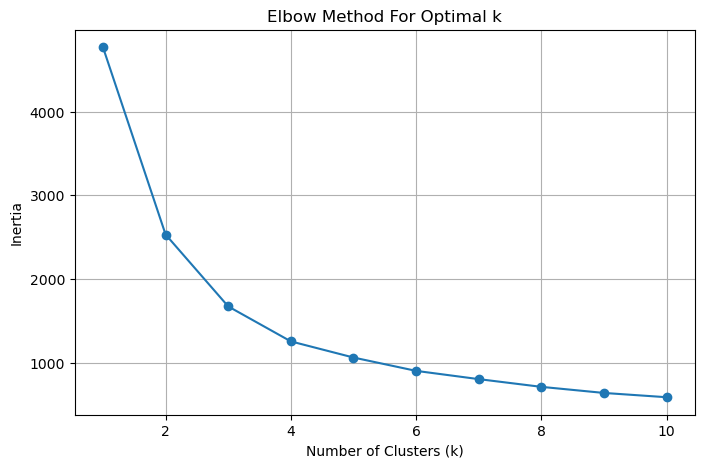

In [106]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [107]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [108]:
print(rfm.info())
print("---------------------------------------------------------------------------")
print(rfm.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1590 entries, 0 to 1589
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       1590 non-null   object 
 1   Recency          1590 non-null   int64  
 2   Frequency        1590 non-null   int64  
 3   Monetary_Profit  1590 non-null   float64
 4   Cluster          1590 non-null   int32  
dtypes: float64(1), int32(1), int64(2), object(1)
memory usage: 56.0+ KB
None
---------------------------------------------------------------------------
  CustomerID  Recency  Frequency  Monetary_Profit  Cluster
0   AA-10315        9         19        447.69050        3
1   AA-10375        7         23        677.47740        3
2   AA-10480      118         20       1516.47518        3
3   AA-10645       27         36       3051.43900        1
4     AA-315        3          7        535.56600        0


In [109]:
cluster_profile = rfm.groupby('Cluster')[
    ['Recency', 'Frequency', 'Monetary_Profit']
].mean().round(2)
print(cluster_profile)

print("-------------------------------------------------")
centers = np.asanyarray(cluster_profile)
print(centers)

         Recency  Frequency  Monetary_Profit
Cluster                                     
0          85.00       7.06           141.39
1          29.86      27.87          3136.97
2         433.53       4.41           146.99
3          32.84      25.39          1037.02
-------------------------------------------------
[[  85.      7.06  141.39]
 [  29.86   27.87 3136.97]
 [ 433.53    4.41  146.99]
 [  32.84   25.39 1037.02]]


In [110]:
k_means_cluster_centers = kmeans.cluster_centers_
centers = scaler.inverse_transform(k_means_cluster_centers).round(2)

print(centers)

[[  85.      7.06  141.39]
 [  29.86   27.87 3136.97]
 [ 433.53    4.41  146.99]
 [  32.84   25.39 1037.02]]


## 6. Visualizing RFM Feature Distributions

We plot histograms to visualize how Recency, Frequency, and Monetary values are distributed across customers.


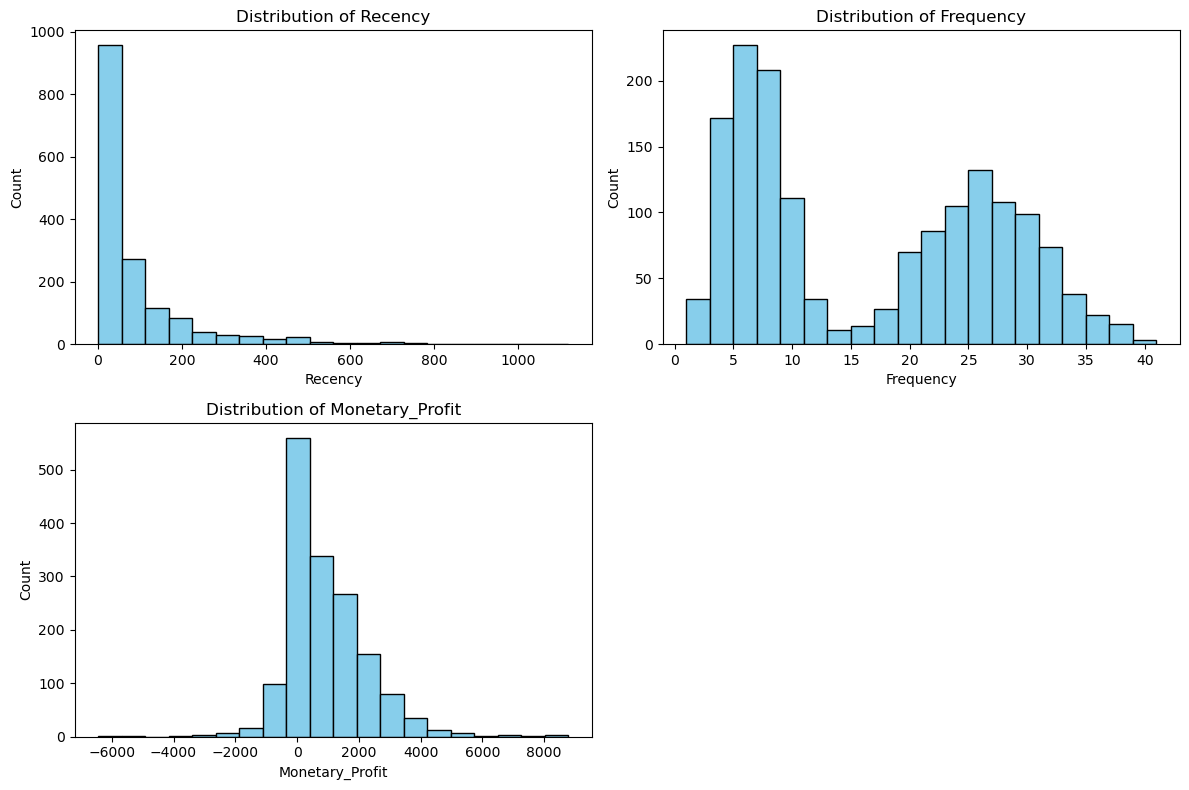

In [111]:
columns = ['Recency', 'Frequency', 'Monetary_Profit']

plt.figure(figsize=(12, 8))

for i, col in enumerate(columns):
    plt.subplot(2, 2, i+1)
    plt.hist(rfm[col], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

## 7. 3D Cluster Visualization

I create a 3D scatter plot of Recency, Frequency, and Monetary values, color-coded by cluster.


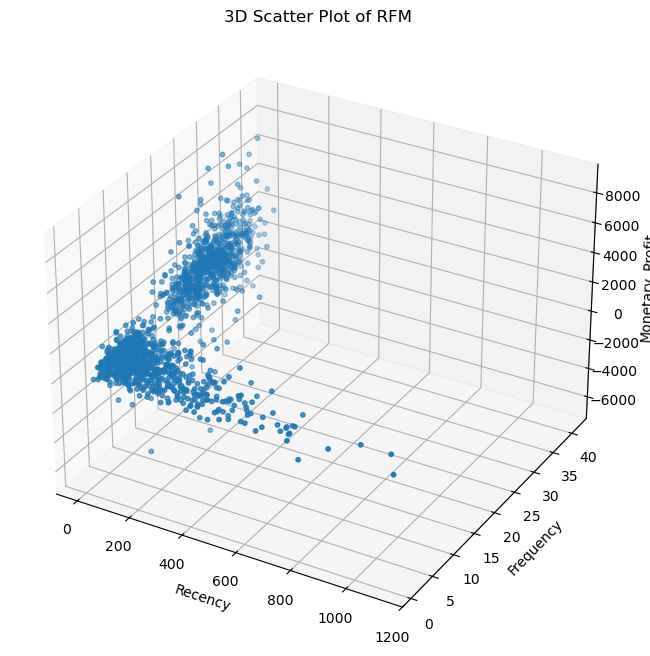

In [ ]:
x = rfm['Recency']
y = rfm['Frequency']
z = rfm['Monetary_Profit']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x, y, z, s=10)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary_Profit')
plt.title('3D Scatter Plot of RFM')

plt.show()

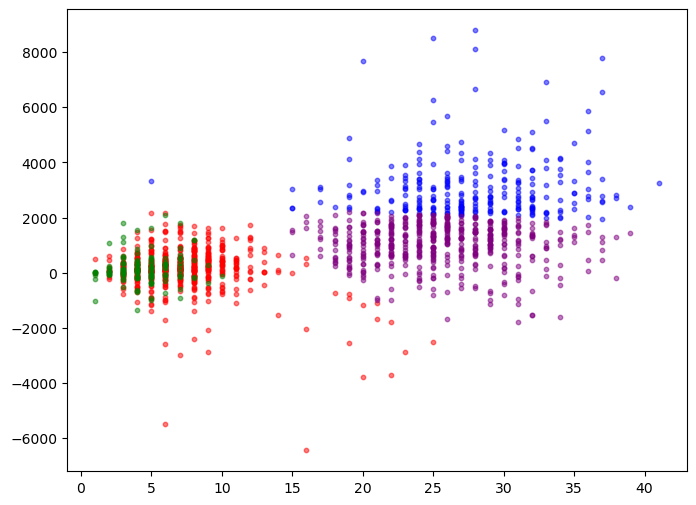

In [130]:
cluster_colors = ['red', 'blue', 'green', 'purple']


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
for i in range(len(centers)):
    mask = rfm['Cluster'] == i
    ax.scatter(
        rfm.loc[mask, 'Frequency'],
        rfm.loc[mask, 'Monetary_Profit'],
        color=cluster_colors[i],
        alpha=0.5,
        s=10
    )

plt.show()

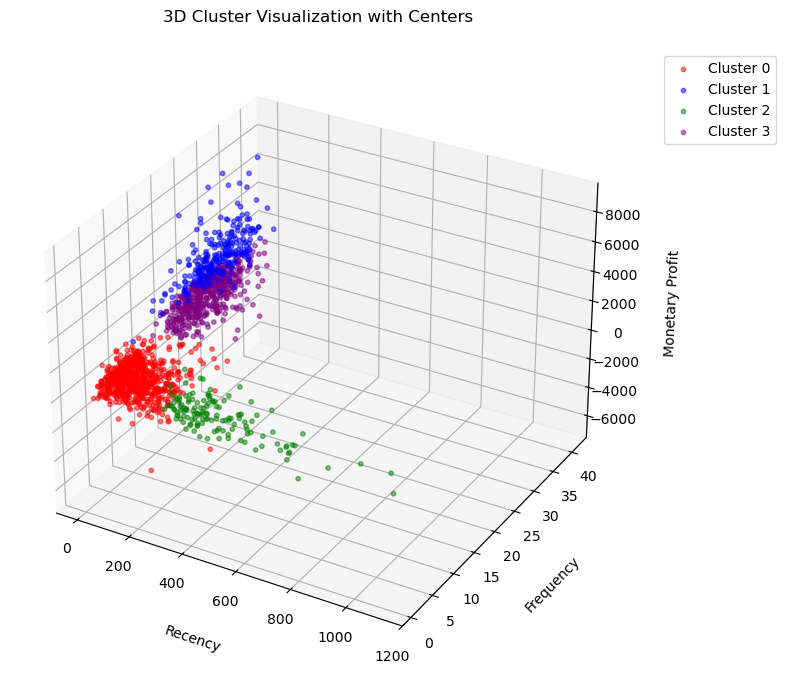

In [ ]:
cluster_colors = ['red', 'blue', 'green', 'purple']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(centers)):
    mask = rfm['Cluster'] == i
    ax.scatter(
        rfm.loc[mask, 'Recency'],
        rfm.loc[mask, 'Frequency'],
        rfm.loc[mask, 'Monetary_Profit'],
        color=cluster_colors[i],
        label=f'Cluster {i}',
        alpha=0.5,
        s=10
    )
    
ax.set_xlabel('Recency', labelpad=15)
ax.set_ylabel('Frequency', labelpad=15)
ax.set_zlabel('Monetary Profit', labelpad=15)
ax.set_title('3D Cluster Visualization', pad=20)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()